In [1]:
import numpy as np
import pandas as pd
import math
import sys, os
from tqdm import tqdm

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color
import matplotlib.colors as mc
import mplcyberpunk
plt.style.use("cyberpunk")

In [4]:
pd.set_option('display.max_columns', 500)
sys.path.append(os.path.realpath('..'))

In [6]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

# Missing Data

In [7]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Missing Data")
missing_data[missing_data['Total'] > 0]

Missing Data


,Total,Percent


# Explore Data

In [8]:
train_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000
mean,8.365175,0.527601,0.265058,2.398881,0.081856,16.955982,49.236868,0.996748,3.310569,0.641308,10.414972,5.720817
std,1.705390,0.173164,0.188267,0.858824,0.023729,10.009710,32.961141,0.001827,0.142321,0.137942,1.028825,0.853146
min,5.000000,0.180000,0.000000,1.200000,0.012000,1.000000,7.000000,0.990070,2.740000,0.390000,8.700000,3.000000
25%,7.200000,0.390000,0.090000,1.900000,0.071000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000
50%,7.950000,0.520000,0.250000,2.200000,0.079000,16.000000,44.000000,0.996700,3.310000,0.610000,10.100000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,24.000000,65.000000,0.997800,3.390000,0.720000,11.000000,6.000000
max,15.900000,1.580000,0.760000,14.000000,0.414000,68.000000,289.000000,1.003690,3.780000,1.950000,14.000000,8.000000


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 0 to 2055
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2056 non-null   float64
 1   volatile acidity      2056 non-null   float64
 2   citric acid           2056 non-null   float64
 3   residual sugar        2056 non-null   float64
 4   chlorides             2056 non-null   float64
 5   free sulfur dioxide   2056 non-null   float64
 6   total sulfur dioxide  2056 non-null   float64
 7   density               2056 non-null   float64
 8   pH                    2056 non-null   float64
 9   sulphates             2056 non-null   float64
 10  alcohol               2056 non-null   float64
 11  quality               2056 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 208.8 KB


In [10]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [12]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
target = ['quality']

# Charting

(-62.984824902723744, 79.71517509727627)

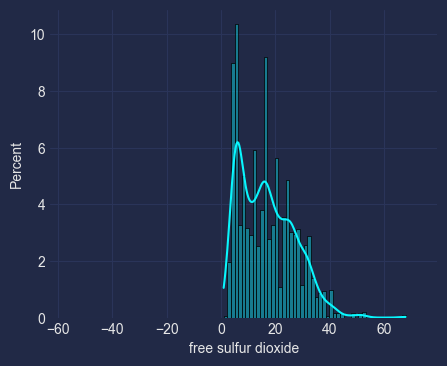

In [13]:
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':50
}


n_cols = 1
n_rows = 1
cell_with_dim = 5
cell_height_dim = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

sns.histplot(train_df[features[5]], label='Train X', color='#08F7FE', ax=ax, **histplot_hyperparams)
xlim = ax.get_xlim()
large_xlin_distance = abs(xlim[np.argmax(xlim)])
mean = train_df[features[0]].describe()['mean']
ax.set_xlim((mean-large_xlin_distance,mean+large_xlin_distance))


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.41it/s]


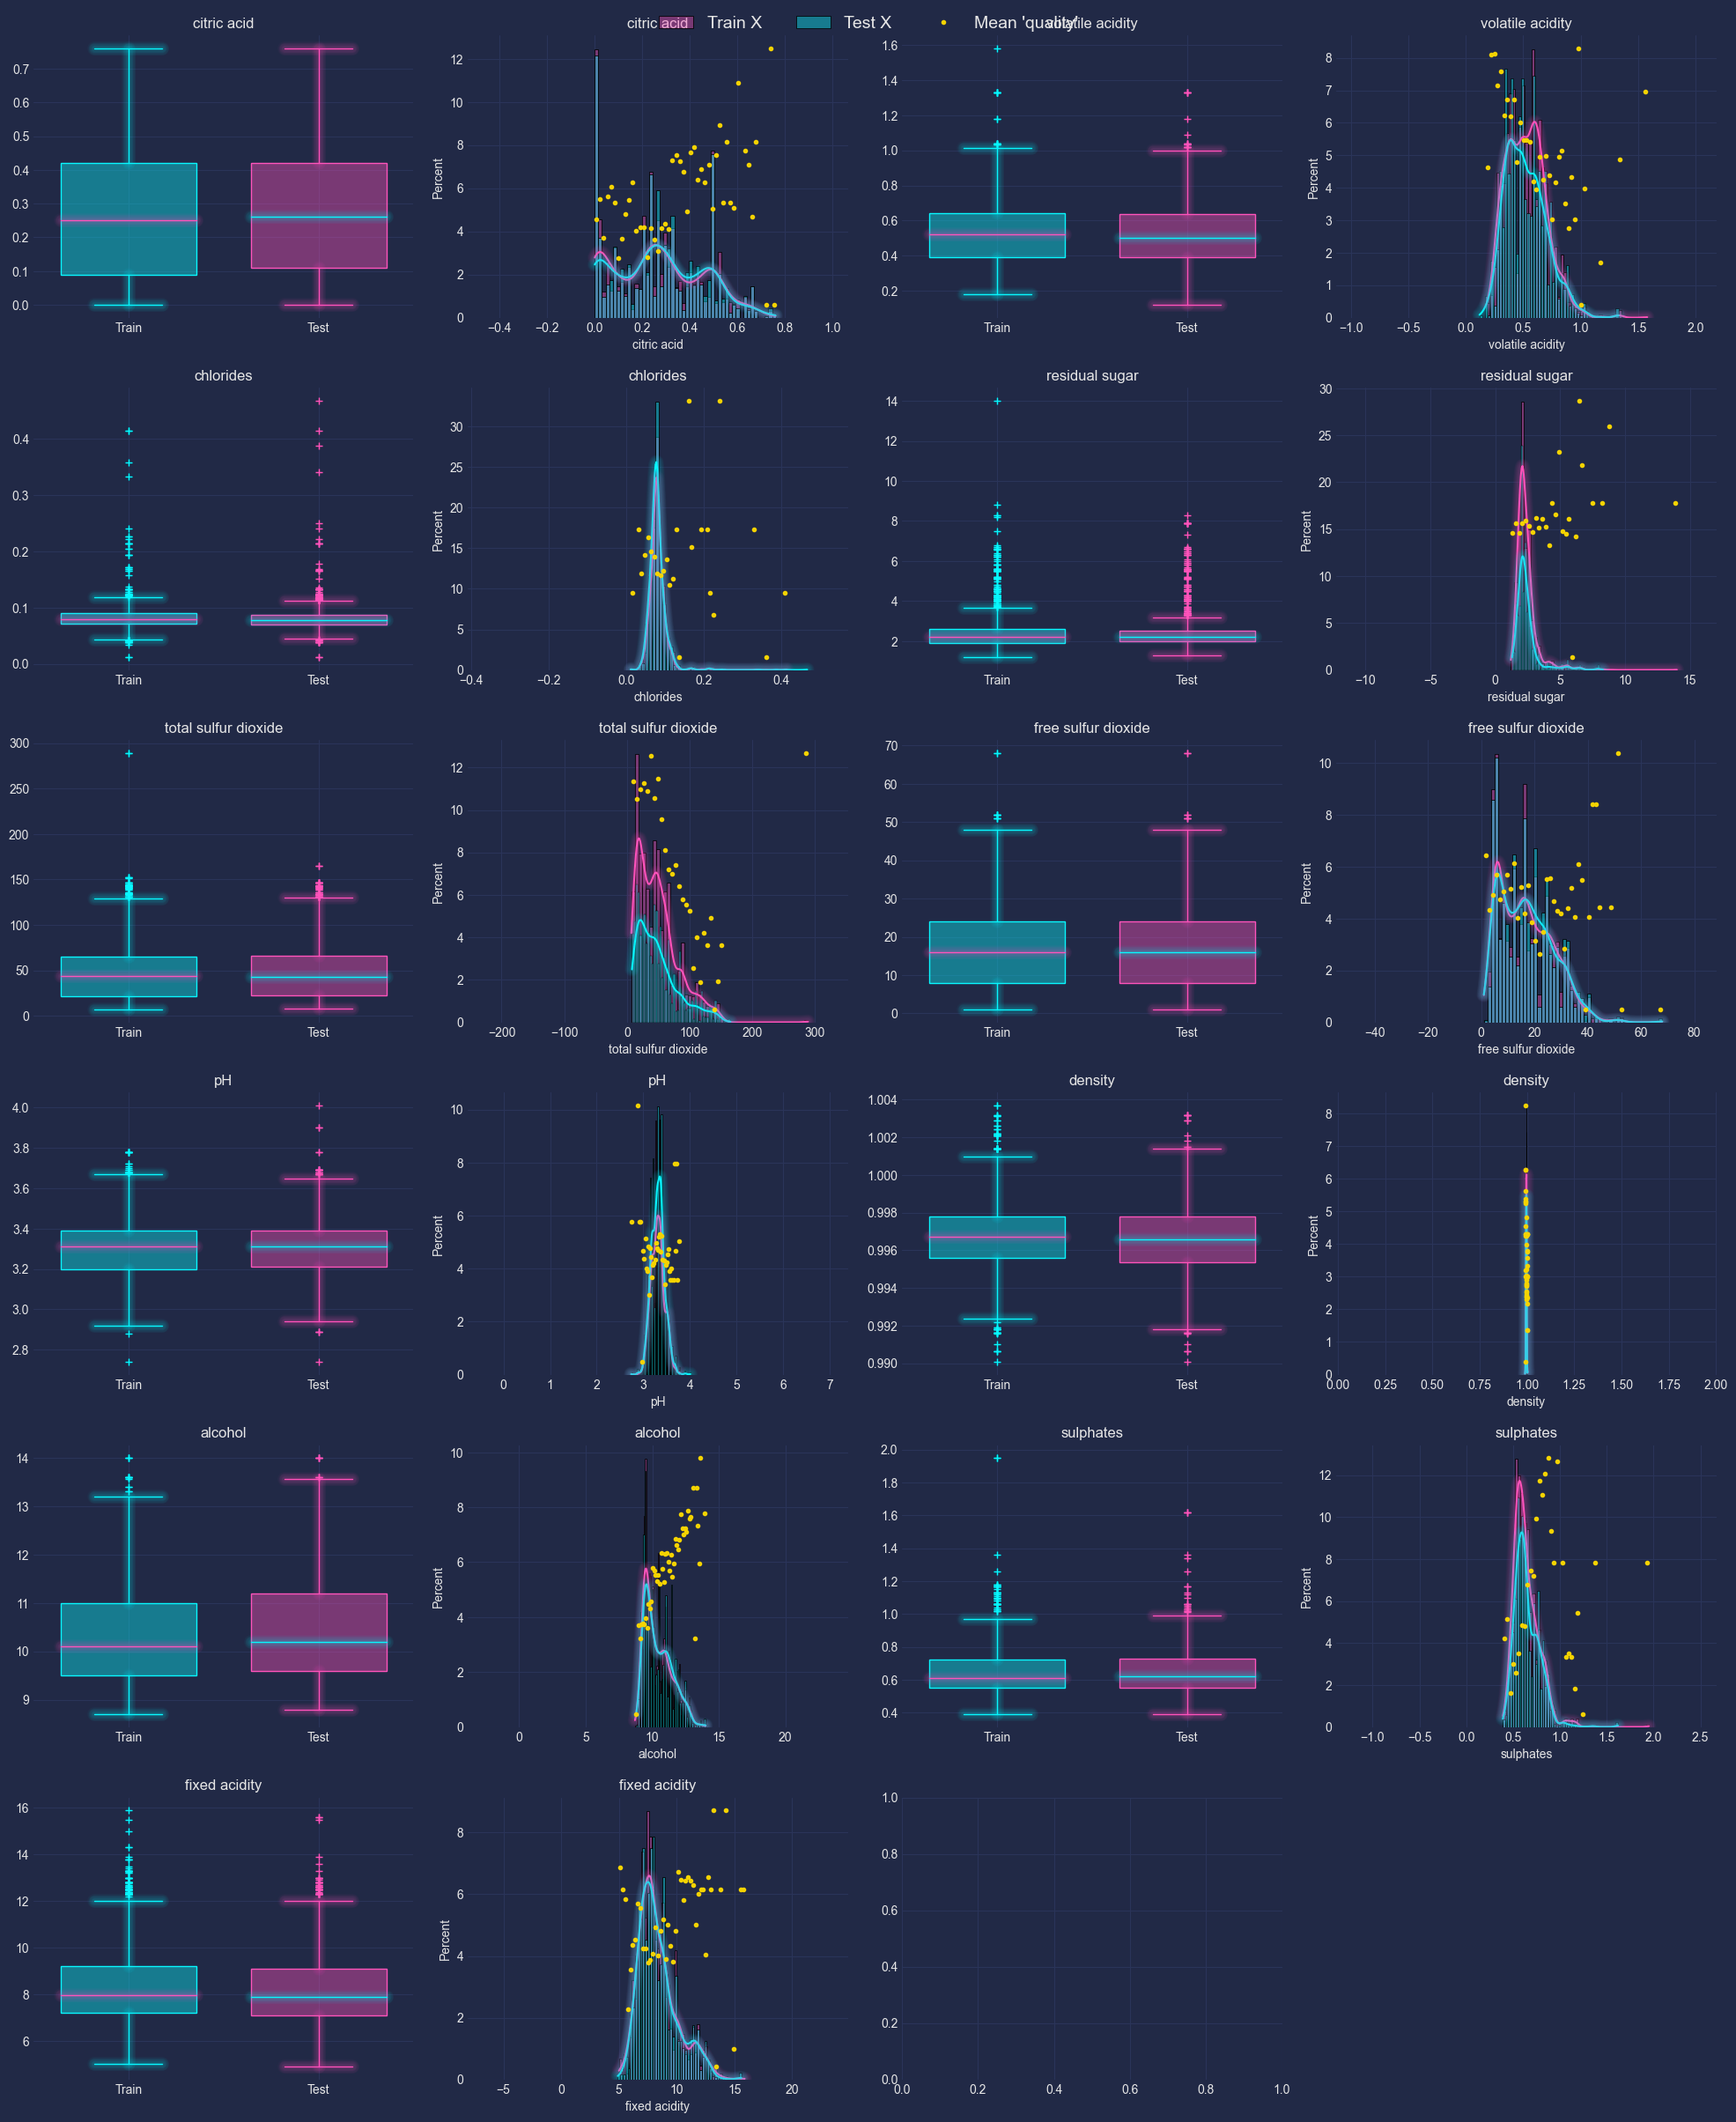

In [15]:
n_cols = 2
n_rows = math.ceil(len(features) / n_cols)
cell_with_dim = 5
cell_height_dim = 4
pad=2
h_pad=4
w_pad=None
n_bins=50

histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

fig, ax = plt.subplots(n_rows, n_cols*2, figsize=(n_cols*2 * cell_with_dim, n_rows * cell_height_dim))
plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)

for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
    a.axis('off')
axs = []
for i in tqdm(range(len(features))):
    row = math.ceil(i / n_cols) - 1
    col = (i % n_cols) 
    
    sources = [train_df, test_df]
    source_labels = ['Train', 'Test']
    color_sets = [['#08F7FE','#FE53BB'], ['#FE53BB','#08F7FE']]
    
    for s, source in enumerate(sources):
        c1 = color_sets[s][0]
        c2 = color_sets[s][1]
        bp = ax[row, col * 2].boxplot(x=source[features[i]], sym='k+', positions=[s], patch_artist=True, labels=[source_labels[s]], widths=cell_with_dim / (cell_with_dim + 2))

        ax[row, col * 2].set_title(features[i])
        for box in bp['boxes']:
            box.set(color=c1, linewidth=1)
            box.set(facecolor=c1)
            r, g, b, a = box.get_facecolor()
            box.set_facecolor((r, g, b, .4)) # alpha layer
        for whisker in bp['whiskers']:
            whisker.set(color=c1, linewidth=1)
        for cap in bp['caps']:
            cap.set(color=c1, linewidth=1)
        for median in bp['medians']:
            median.set(color=c2)
        for flier in bp['fliers']:
            flier.set(color=c1, linewidth=1)
            flier.set(markeredgecolor=c1)
            
            
        
    sns.histplot(train_df[features[i]], label='Train X', color=c1, ax=ax[row, (col * 2) + 1], **histplot_hyperparams)
    sns.histplot(test_df[features[i]], label='Test X', color=c2, ax=ax[row, (col * 2) + 1], **histplot_hyperparams)
    ax[row, (col * 2) + 1].set_title(features[i])
    xlim = ax[row, (col * 2) + 1].get_xlim()
    large_xlin_distance = abs(xlim[np.argmax(xlim)])
    mean = train_df[features[i]].describe()['mean']
    ax[row, (col * 2) + 1].set_xlim((mean-large_xlin_distance,mean+large_xlin_distance))
        
    mplcyberpunk.make_lines_glow(ax[row, col * 2])
    mplcyberpunk.make_lines_glow(ax[row, (col * 2) + 1])
            

    
    sub_ax = add_secondary_plot(train_df, features[i], target[0], ax[row, (col * 2) + 1], n_bins, color='#F5D300')

    axs.append(ax[row, (col * 2) + 1].get_legend_handles_labels())
    axs.append(sub_ax.get_legend_handles_labels())
    
        
leg_handles = []
leg_labels = []
    
for axis in axs:
    if axis[1][0] not in leg_labels:
        leg_labels.extend(axis[1])
        leg_handles.extend(axis[0])

fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, n_rows * 0.0005 + 1), fontsize=14, ncol=len(features) + 2)

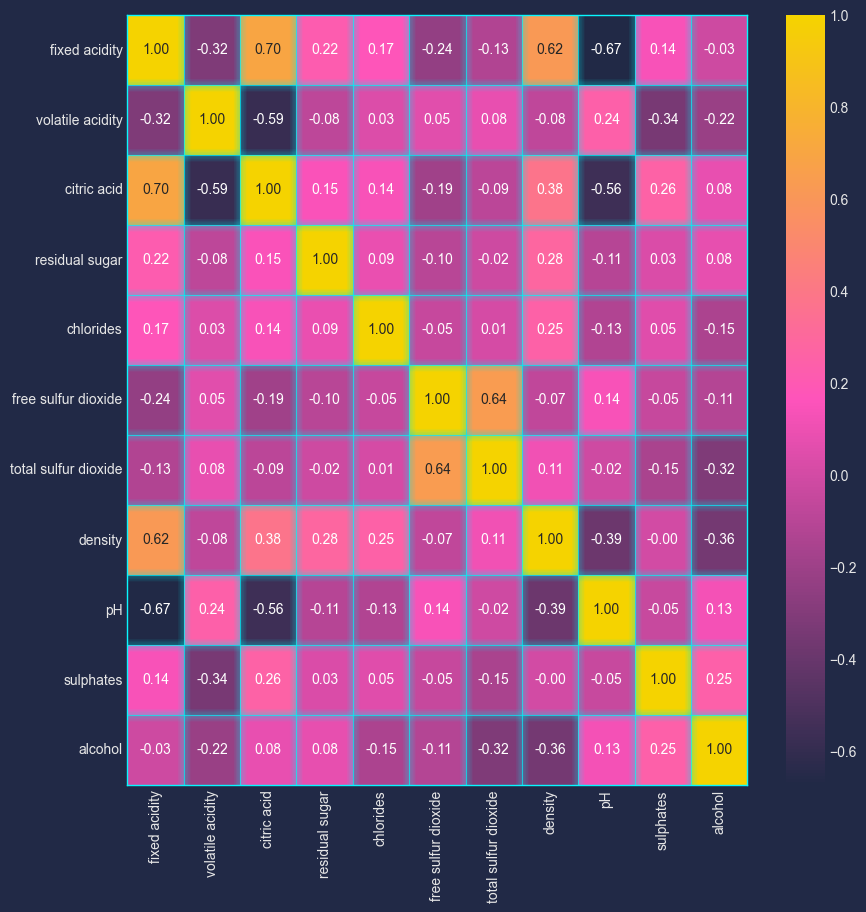

In [18]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#212946', '#FE53BB', '#F5D300']
th = [0, 0.5, 1]

cdict = NonLinCdict(th, hc)
cm = mc.LinearSegmentedColormap('test', cdict)


fig, ax = plt.subplots(1, figsize=(10,10))
res = sns.heatmap(train_df[features].corr(), annot=True, cmap=cm, ax = ax, fmt='.2f')
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('#08F7FE')
    
xticks = ax.get_xticks()
for i in range(len(xticks)-1):  
    ax.axvline( x=(xticks[i] + xticks[i+1]) / 2, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=0.5, color='#08F7FE')
    
yticks = ax.get_yticks()
for i in range(len(yticks)-1):  
    ax.axhline( y=(yticks[i] + yticks[i+1]) / 2, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=0.5, color='#08F7FE')
    
    
# plt.savefig("Heatmap.png")
mplcyberpunk.make_lines_glow(ax, diff_linewidth=0.9)
plt.show()